In [396]:
import functools
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
dtype = tf.float64

# Resources for learning TFP
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/NoUTurnSampler
# https://www.tensorflow.org/probability/overview
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc
# https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution
# https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model

# To better understand event_shape, batch_shape, sample_shape:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Distribution
# https://www.youtube.com/watch?v=zWXTpZX4PPo

In [345]:
# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

In [346]:
def stickbreak(v):
    cumprod_one_minus_v = tf.math.cumprod(1 - v)
    one_v = tf.pad(v, [[0, 1]], "CONSTANT", constant_values=1)
    c_one = tf.pad(cumprod_one_minus_v, [[1, 0]], "CONSTANT", constant_values=1)
    return one_v * c_one 

# Example:
# stickbreak(np.random.rand(3))

In [367]:
# See: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily
# See: https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model
def create_dp_sb_gmm(nobs, K, dtype=np.float64):
    return tfd.JointDistributionNamed(dict(
        # Mixture means
        mu = tfd.Independent(
            tfd.Normal(np.zeros(K, dtype), 3),
            reinterpreted_batch_ndims=1
        ),
        # Mixture scales
        sigma = tfd.Independent(
            tfd.Gamma(concentration=np.ones(K, dtype), rate=10),
            reinterpreted_batch_ndims=1
        ),
        # Mixture weights (stick-breaking construction)
        alpha = tfd.Gamma(concentration=np.float64(1.0), rate=10.0),
        v = lambda alpha: tfd.Independent(
            tfd.Beta(np.ones(K - 1, dtype), alpha),
            reinterpreted_batch_ndims=1
        ),
        # v = tfd.Dirichlet(np.ones(K, dtype) / K),

        # Observations (likelihood)
        obs = lambda mu, sigma, v: tfd.Sample(tfd.MixtureSameFamily(
            # This will be marginalized over.
            mixture_distribution=tfd.Categorical(probs=stickbreak(v)),
            # mixture_distribution=tfd.Categorical(probs=v),
            components_distribution=tfd.Normal(mu, sigma)),
            sample_shape=nobs)
    ))

In [368]:
# print(dp_sb_gmm.resolve_graph())
dp_sb_gmm = create_dp_sb_gmm(13, 5)
sample = dp_sb_gmm.sample()
dp_sb_gmm.log_prob(**sample)
# sample

<tf.Tensor: shape=(), dtype=float64, numpy=30.20768597132716>

In [369]:
sample

{'alpha': <tf.Tensor: shape=(), dtype=float64, numpy=0.08339997767843257>,
 'v': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.99987106, 0.9851154 , 1.        , 0.80483409])>,
 'sigma': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.10614074, 0.00094163, 0.0539674 , 0.02720146, 0.09653697])>,
 'mu': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([-3.37064307, -5.60177339,  0.29258122, -0.84692047,  5.7293103 ])>,
 'obs': <tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([-3.44730658, -3.32000591, -3.25178169, -3.38955375, -3.3127501 ,
        -3.15225799, -3.35755759, -3.30439835, -3.42426798, -3.50964646,
        -3.40954159, -3.49254125, -3.55857397])>}

In [370]:
dp_sb_gmm.log_prob(mu=tfd.Normal(np.float64(0), 1).sample(K),
                   sigma=tfd.Uniform(np.float64(0), 1).sample(K),
                   alpha=tf.cast(1, dtype),
                   v=tfd.Beta(np.float64(1), 1).sample(K - 1),
                   obs=np.random.randn(100))

InvalidArgumentError: Incompatible shapes: [4] vs. [6] [Op:Xlogy]

In [383]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
    simdata = json.load(f)
    
y = np.array(simdata['y'], dtype)

dtype('float64')

In [ ]:
ncomponents = 10

model = create_dp_sb_gmm(nobs=len(simdata['y']), K=ncomponents)

def joint_log_prob(obs, mu, sigma, alpha, v):
    return model.log_prob(obs=obs, 
                          mu=mu, sigma=sigma,
                          alpha=alpha, v=v)
    
_ = joint_log_prob(y, 
                   np.random.randn(10),
                   np.random.rand(10),
                   np.float64(1),
                   np.random.rand(9))

unnormalized_posterior_log_prob = functools.partial(joint_log_prob, y)

# Create initial state?
initial_state = [
    tf.zeros(ncomponents, dtype, name='mu'),
    tf.ones(ncomponents, dtype, name='sigma'),
    tf.ones([], dtype, name='alpha'),
    tf.fill(ncomponents - 1, value=np.float64(0.9), name='v')
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Sigmoid()
]

@tf.function(autograph=False)
def sample():
    return tfp.mcmc.sample_chain(
        num_results=500,
        num_burnin_steps=500,
        current_state=initial_state,
        kernel=tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                # HMC:
                # inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                #      target_log_prob_fn=unnormalized_posterior_log_prob,
                #      step_size=0.01,
                #      num_leapfrog_steps=100),
                # NUTS:
                inner_kernel=tfp.mcmc.NoUTurnSampler(
                     target_log_prob_fn=unnormalized_posterior_log_prob,
                     step_size=0.01, max_tree_depth=10
                ),
                bijector=bijectors),
             num_adaptation_steps=400),
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

[mu, sigma, alpha, v], is_accepted = sample()

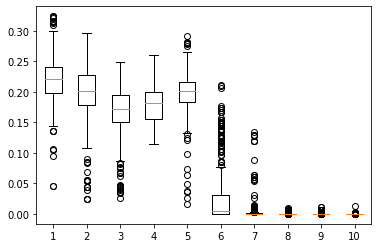

In [440]:
eta = np.apply_along_axis(stickbreak, 1, v)
plt.boxplot(eta);

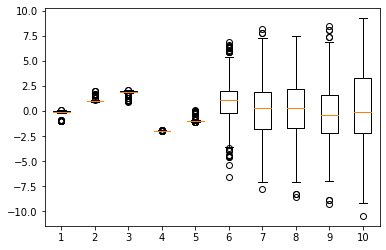

In [428]:
plt.boxplot(mu.numpy());

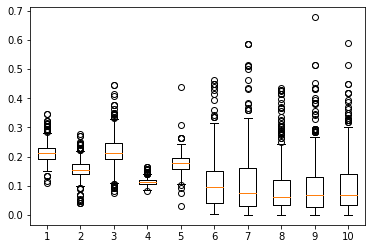

In [442]:
plt.boxplot(sigma.numpy());

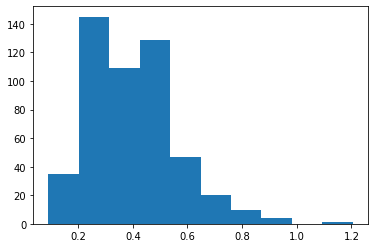

In [444]:
plt.hist(alpha.numpy());